In [ ]:
!pip install yfinance
!pip install evds

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import time
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import plot_tree

from evds import evdsAPI

evds = evdsAPI('') ##TOKEN

warnings.filterwarnings("ignore")

# Data Preparing

## TRY/USD
##### Data Source: Central Bank of the Republic of Türkiye

In [2]:
data_raw = evds.get_data(series = ['TP.DK.USD.A.YTL', 'TP.DK.USD.S.YTL'],
                         startdate = '31-12-2004',
                         enddate = '01-01-2024',
                         frequency=1)

df = data_raw.copy()
df.columns = ['Date', 'Bid_Price', 'Ask_Price']
df.drop('Ask_Price', axis=1, inplace=True)
df.dropna(inplace=True)
df.loc[:, 'Date'] = pd.DatetimeIndex(data=df.loc[:, 'Date'],
                                     dayfirst=True)

df.reset_index(inplace=True, drop=True)
df.set_index('Date', inplace=True)

df.loc[:,'Daily_Return'] = np.log(df.Bid_Price / df.shift(1).Bid_Price)
df = df.iloc[1:,]

In [3]:
df_vol = df.resample('M').agg({'Daily_Return': 'std'})
df_vol = df_vol.rename(columns={'Daily_Return': 'Volatility'})

df_vol['Annualized_Volatility'] = df_vol['Volatility'] * (252 ** 0.5)

threshold = 0.1

df_vol['Vol_Level'] = df_vol['Annualized_Volatility'].apply(lambda x: 1 if x > threshold else 0)

## BIST100
##### Data Source: Yahoo Finance

In [4]:
BIST100 = yf.download('XU100.IS', start='2004-12-01', end='2024-01-01')
BIST100_close = BIST100['Adj Close']
BIST100_close[BIST100_close.index <= dt.datetime(2020, 7, 24)] /= 100
BIST100_volume = BIST100['Volume']

BIST100_close_monthly = BIST100_close.resample('M').mean()
BIST100_close_monthly = BIST100_close_monthly.pct_change().dropna()
BIST100_volume_monthly = BIST100_volume.resample('M').mean()
BIST100_volume_monthly = BIST100_volume_monthly.pct_change().dropna()


[*********************100%%**********************]  1 of 1 completed


## VIX
##### Data Source: Yahoo Finance

In [5]:
VIX_close = yf.download('^VIX', start='2004-12-31', end='2024-01-01')['Adj Close']

VIX_close_monthly = VIX_close.resample('M').last()
VIX_close_monthly = VIX_close_monthly.pct_change().dropna()


[*********************100%%**********************]  1 of 1 completed


## Deposit Interest Rates
##### Data Source: Central Bank of the Republic of Türkiye

In [6]:
deposit_interest = evds.get_data(series=['TP.EUR.MT06', 'TP.TRY.MT06', 'TP.USD.MT06'],
                                 startdate='31-12-2004',
                                 enddate='29-12-2023',
                                 frequency=1)

deposit_interest.loc[:, 'Tarih'] = pd.DatetimeIndex(data=deposit_interest.loc[:, 'Tarih'],
                                                   dayfirst=True)

deposit_interest.reset_index(inplace=True, drop=True)
deposit_interest.set_index('Tarih', inplace=True)

deposit_interest = deposit_interest.loc[:, ['TP_EUR_MT06', 'TP_TRY_MT06', 'TP_USD_MT06']]

deposit_interests = deposit_interest.resample('M').mean()
deposit_interests = deposit_interests.pct_change().dropna()

## 'TP.EUR.MT06' --> Toplam (EUR Üzerinden Açılan Mevduatlar)(Akım %)-Düzey
## 'TP.TRY.MT06' --> Toplam (TL Üzerinden Açılan Mevduatlar)(Akım %)-Düzey
## 'TP.USD.MT06' --> Toplam (USD Üzerinden Açılan Mevduatlar)(Akım %)-Düzey

## Inflation
##### Data Source: Central Bank of the Republic of Türkiye

In [7]:
CPI_data = evds.get_data(series=['TP.FE.OKTG01'],
                         startdate='31-12-2004',
                         enddate='31-12-2023',
                         frequency=1)

CPI_data['Inflation'] = round(CPI_data.TP_FE_OKTG01.pct_change() * 100, 2)
CPI_data.Tarih = pd.to_datetime(CPI_data.Tarih)
CPI_data.set_index('Tarih', inplace=True)
CPI_data = CPI_data.resample('M').last()

## 'TP.FE.OKTG01' --> TÜİK - Fiyat Endeksi-Özel Kapsamlı TÜFE Göstergeleri (2003=100) (Yeni Seri) / Tüketici Fiyat Endeksi (Genel)

## GNP
##### Data Source: Central Bank of the Republic of Türkiye

In [8]:
gnp_data = evds.get_data(series=['TP.GSYIH26.GY.CF'],
              startdate='01-01-2005',
              enddate='01-01-2024',
              frequency=1)

# Convert 'Tarih' column to datetime
gnp_data['Tarih'] = pd.to_datetime(gnp_data['Tarih'])

# Set 'Tarih' column as index
gnp_data.set_index('Tarih', inplace=True)

gnp_data = gnp_data.resample('M').last().ffill()

## 'TP.GSYIH26.GY.CF' --> Gayrisafi Yurtiçi Hasıla (Alıcı fiyatlarıyla)(Bin TL) - Gelir yöntemi ile

## Google Trends
##### Data Source: Google Trends
###### Queries: dolar; tl dolar; dolar kac; dolar kac tl; dolar kuru; dolar ne kadar

In [ ]:
url = 'https://raw.githubusercontent.com/MeminT99/Forecasting_Exchange_Rate_Volatility/main/data/google_trends.csv'

trend_data = pd.read_csv(url)

trend_data['date'] = pd.to_datetime(trend_data['date'])
trend_data = trend_data.dropna(subset=['date'])
trend_data.set_index('date', inplace=True)
trend_data['total'] = trend_data.sum(axis=1)

trend_total = trend_data['total']

## Gathering All Data

In [10]:
model_data = pd.DataFrame({'BIST100_Value_mean': BIST100_close_monthly,
                           'BIST100_Volume_mean': BIST100_volume_monthly,
                           'GNP(TRY)': gnp_data['TP_GSYIH26_GY_CF'],
                           'Inflation(%)': CPI_data['Inflation'][1:],
                           'Deposit_Interest(TRY)': deposit_interests['TP_TRY_MT06'],
                           'Deposit_Interest(USD)': deposit_interests['TP_USD_MT06'],
                           'Deposit_Interest(EUR)': deposit_interests['TP_EUR_MT06'],
                           'VIX': VIX_close_monthly,
                           'Google_Trends': trend_total,
                           'Annualized_Volatility': df_vol['Annualized_Volatility'],
                           'Volatility_Level': df_vol['Vol_Level']})

model_data['GNP(TRY)'] = model_data['GNP(TRY)'].ffill()
model_data.dropna(inplace=True)
bins = [2, 6, 7, 20, 54.25, 100, 600]
labels = [0, 1, 2, 3, 4, 5]
model_data['Google_Trends'] = pd.cut(model_data['Google_Trends'], bins=bins, labels=labels, include_lowest=True).astype(int)

scaler = StandardScaler()
model_data['GNP(TRY)'] = scaler.fit_transform(model_data[['GNP(TRY)']])

In [11]:
model_cols = model_data.columns

# Create lagged features for each predictor separately
for column in model_cols:
    if column not in ['Volatility_Level', 'Annualized_Volatility']:
        model_data[f'{column}_lag'] = model_data[column].shift(1)

# Drop rows with NaN values due to shifting
model_data.dropna(inplace=True)

In [12]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 227 entries, 2005-02-28 to 2023-12-31
Freq: M
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BIST100_Value_mean         227 non-null    float64
 1   BIST100_Volume_mean        227 non-null    float64
 2   GNP(TRY)                   227 non-null    float64
 3   Inflation(%)               227 non-null    float64
 4   Deposit_Interest(TRY)      227 non-null    float64
 5   Deposit_Interest(USD)      227 non-null    float64
 6   Deposit_Interest(EUR)      227 non-null    float64
 7   VIX                        227 non-null    float64
 8   Google_Trends              227 non-null    int64  
 9   Annualized_Volatility      227 non-null    float64
 10  Volatility_Level           227 non-null    float64
 11  BIST100_Value_mean_lag     227 non-null    float64
 12  BIST100_Volume_mean_lag    227 non-null    float64
 13  GNP(TRY)_lag           

### **Details for the data**

#### Contains 2005-2024 values monthly.

- `BIST100_Value_mean`: Mean value of percentage change in BIST100 index.
  - *Metric* (float)
  
- `BIST100_Volume_mean`: Mean value of percentage change in BIST100 index volume.
  - *Metric* (float)
  
- `GNP(TRY)`: Gross National Product in Turkish Lira.
  - *Metric* (float)
  
- `Inflation(%)`: Inflation rate.
  - *Metric* (float)
  
- `Deposit_Interest(TRY)`: Interest rate change monthly for deposits in Turkish Lira.
  - *Metric* (float)
  
- `Deposit_Interest(USD)`: Interest rate change monthly for deposits in US Dollars.
  - *Metric* (float)
  
- `Deposit_Interest(EUR)`: Interest rate change monthly for deposits in Euros.
  - *Metric* (float)
  
- `VIX`: Percentage change for Volatility Index.
  - *Metric* (float)
  
- `Google_Trends`: Google Trends data.
  - *Categorical* (category)
    - (2, 6): 0 - Very Low
    - (6, 7): 1 - Low
    - (7, 20): 2 - Below Average
    - (20, 54.25): 3 - Average
    - (54.25, 100): 4 - Above Average
    - (100, 600): 5 - High
  
- `Annualized_Volatility`: Annualized volatility of TL/USD exchange rate.
  - *Metric* (float)
  
- `Volatility_Level`: Binary variable indicating high (1) or low (0) volatility level.
  - *Categorical* (int)
  
- `BIST100_Value_mean_lag`: Lagged mean value of percentage change in BIST100 index.
  - *Metric* (float)
  
- `BIST100_Volume_mean_lag`: Lagged mean value of percentage change in BIST100 index volume.
  - *Metric* (float)
  
- `GNP(TRY)_lag`: Lagged Gross National Product in Turkish Lira.
  - *Metric* (float)
  
- `Inflation(%)_lag`: Lagged inflation rate.
  - *Metric* (float)
  
- `Deposit_Interest(TRY)_lag`: Lagged interest rate change monthly for deposits in Turkish Lira.
  - *Metric* (float)
  
- `Deposit_Interest(USD)_lag`: Lagged interest rate change monthly for deposits in US Dollars.
  - *Metric* (float)
  
- `Deposit_Interest(EUR)_lag`: Lagged interest rate change monthly for deposits in Euros.
  - *Metric* (float)
  
- `VIX_lag`: Lagged percentage change for Volatility Index.
  - *Metric* (float)
  
- `Google_Trends_lag`: Lagged Google Trends data.
  - *Categorical* (category)
    - (2, 6): 0 - Very Low
    - (6, 7): 1 - Low
    - (7, 20): 2 - Below Average
    - (20, 54.25): 3 - Average
    - (54.25, 100): 4 - Above Average
    - (100, 600): 5 - High

# Machine Learning Applications

In [13]:
X = model_data.drop(['Annualized_Volatility', 'Volatility_Level'], axis=1)
y = model_data['Volatility_Level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=48)

### Model Evaluation - Selection

In [14]:
# Initialize models and their hyperparameters for GridSearchCV
models = {
    "KNN": (
        KNeighborsClassifier(),
        {
            "n_neighbors": [2, 3, 5, 7, 9],
            "weights": ['uniform', 'distance'],
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
            "leaf_size": [10, 20, 30, 40, 50]
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(),
        {
            "n_estimators": [50, 100, 200, 300],
            "learning_rate": [0.01, 0.1, 0.5],
            "algorithm": ['SAMME', 'SAMME.R']
        }
    ),
    "Gradient Boosting": (
        GradientBoostingClassifier(),
        {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.1, 0.05],
            "max_depth": [3, 4, 5],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    ),
    "Random Forest": (
        RandomForestClassifier(),
        {
            "n_estimators": [50, 100, 200, 300],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False]
        }
    ),
    "Logistic Regression": (
        LogisticRegression(),
        {
            "penalty": ['l1', 'l2', 'elasticnet', 'none'],
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
            "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            "max_iter": [100, 200, 300, 400, 500]
        }
    ),
    "Decision Tree": (
        DecisionTreeClassifier(),
        {
            "criterion": ['gini', 'entropy'],
            "splitter": ['best', 'random'],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    ),
    "Naive Bayes": (
        GaussianNB(),
        {}
    ),
    "SVM": (
        SVC(probability=True),
        {
            "C": [0.001, 0.01, 0.1, 1, 10],
            "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
            "gamma": ['scale', 'auto']
        }
    )
}

# Results dictionary
results = {
    "Model": [],
    "Best Model": [],
    "Best Parameters": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "AUC": [],
    "TP": [],
    "TN": [],
    "FP": [],
    "FN": []
}

# Train, tune and evaluate models
model_num = 1
for name, (model, params) in models.items():
    print(f'{name} Tuning ({model_num}/{len(models)}) started!')
    start_time = time.time()

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, params, cv=10, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Evaluate model performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Store results
    results["Model"].append(name)
    results["Best Model"].append(best_model)
    results["Best Parameters"].append(grid_search.best_params_)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1 Score"].append(f1)
    results["AUC"].append(auc)
    results["TP"].append(tp)
    results["TN"].append(tn)
    results["FP"].append(fp)
    results["FN"].append(fn)

    print(f'{name} finished!')
    print(f'Accuracy: {round(accuracy*100, 2)}%')
    if auc is not None:
        print(f'AUC: {round(auc, 2)}')
    end_time = time.time()
    training_time = end_time - start_time
    train_min = training_time // 60
    train_sec = round(training_time % 60, 2)
    print(f'Training time: {train_min} minutes {train_sec} seconds\n')
    model_num += 1

# Convert results to DataFrame
results_df = pd.DataFrame(results)

KNN Tuning (1/8) started!
KNN finished!
Accuracy: 68.42%
AUC: 0.72
Training time: 0.0 minutes 28.0 seconds

AdaBoost Tuning (2/8) started!
AdaBoost finished!
Accuracy: 64.91%
AUC: 0.73
Training time: 1.0 minutes 18.53 seconds

Gradient Boosting Tuning (3/8) started!
Gradient Boosting finished!
Accuracy: 73.68%
AUC: 0.74
Training time: 11.0 minutes 45.96 seconds

Random Forest Tuning (4/8) started!
Random Forest finished!
Accuracy: 68.42%
AUC: 0.75
Training time: 11.0 minutes 53.46 seconds

Logistic Regression Tuning (5/8) started!
Logistic Regression finished!
Accuracy: 64.91%
AUC: 0.76
Training time: 0.0 minutes 54.36 seconds

Decision Tree Tuning (6/8) started!
Decision Tree finished!
Accuracy: 59.65%
AUC: 0.56
Training time: 0.0 minutes 8.8 seconds

Naive Bayes Tuning (7/8) started!
Naive Bayes finished!
Accuracy: 61.4%
AUC: 0.77
Training time: 0.0 minutes 0.13 seconds

SVM Tuning (8/8) started!
SVM finished!
Accuracy: 54.39%
AUC: 0.74
Training time: 0.0 minutes 4.8 seconds



### Neural Network

In [15]:
class NeuralNetworkClassifier:
    def __init__(self, input_shape, layers=[128, 64, 32], dropout_rate=0.5, learning_rate=0.001, regularization_rate=0.01):
        self.input_shape = input_shape
        self.layers = layers
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.regularization_rate = regularization_rate
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(self.layers[0], activation='relu', input_shape=(self.input_shape,), kernel_regularizer=l2(self.regularization_rate)))
        model.add(BatchNormalization())
        model.add(Dropout(self.dropout_rate))

        for units in self.layers[1:]:
            model.add(Dense(units, activation='relu', kernel_regularizer=l2(self.regularization_rate)))
            model.add(BatchNormalization())
            model.add(Dropout(self.dropout_rate))

        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, patience=10):
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        self.history = self.model.fit(X_train, y_train,
                                      validation_split=validation_split,
                                      epochs=epochs,
                                      batch_size=batch_size,
                                      callbacks=[early_stopping])

    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        return loss, accuracy

    def predict(self, X):
        predictions = self.model.predict(X)
        return (predictions > 0.5).astype(int)

    def get_results_row(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_prob = self.model.predict(X_test)
        loss, accuracy = self.evaluate(X_test, y_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        results_row = {
            "Model": "Neural Network",
            "Best Model": self.model,
            "Best Parameters": {
                "layers": self.layers,
                "dropout_rate": self.dropout_rate,
                "learning_rate": self.learning_rate,
                "regularization_rate": self.regularization_rate
            },
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC": auc,
            "TP": tp,
            "TN": tn,
            "FP": fp,
            "FN": fn
        }

        return results_row

input_shape = X_train.shape[1]
nn_classifier = NeuralNetworkClassifier(input_shape=input_shape, layers=[256, 128, 64], dropout_rate=0.4, learning_rate=0.0001, regularization_rate=0.001)

nn_classifier.train(X_train, y_train)
nn_results_row = nn_classifier.get_results_row(X_test, y_test)


Epoch 1/100
5/5 [==============================] - 6s 95ms/step - loss: 1.3548 - accuracy: 0.5147 - val_loss: 1.0143 - val_accuracy: 0.5294
Epoch 2/100
5/5 [==============================] - 0s 15ms/step - loss: 1.3399 - accuracy: 0.5515 - val_loss: 1.0010 - val_accuracy: 0.4412
Epoch 3/100
5/5 [==============================] - 0s 21ms/step - loss: 1.2914 - accuracy: 0.5515 - val_loss: 0.9897 - val_accuracy: 0.5000
Epoch 4/100
5/5 [==============================] - 0s 22ms/step - loss: 1.3392 - accuracy: 0.4926 - val_loss: 0.9820 - val_accuracy: 0.5588
Epoch 5/100
5/5 [==============================] - 0s 26ms/step - loss: 1.3694 - accuracy: 0.5074 - val_loss: 0.9758 - val_accuracy: 0.5882
Epoch 6/100
5/5 [==============================] - 0s 24ms/step - loss: 1.2900 - accuracy: 0.5074 - val_loss: 0.9689 - val_accuracy: 0.6471
Epoch 7/100
5/5 [==============================] - 0s 22ms/step - loss: 1.1703 - accuracy: 0.5441 - val_loss: 0.9626 - val_accuracy: 0.6471
Epoch 8/100
5/5 [===

In [16]:
results_df.iloc[-1] = nn_results_row
results_df.sort_values(by='Accuracy', ascending=False)

,Model,Best Model,Best Parameters,Accuracy,Precision,Recall,F1 Score,AUC,TP,TN,FP,FN
2,Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.05, 'max_depth': 5, 'min_s...",0.736842,0.655172,0.791667,0.716981,0.743687,19,23,10,5
0,KNN,"KNeighborsClassifier(leaf_size=10, n_neighbors=7)","{'algorithm': 'auto', 'leaf_size': 10, 'n_neig...",0.684211,0.607143,0.708333,0.653846,0.722854,17,22,11,7
3,Random Forest,"(DecisionTreeClassifier(max_depth=10, max_feat...","{'bootstrap': True, 'max_depth': 10, 'min_samp...",0.684211,0.588235,0.833333,0.689655,0.747475,20,19,14,4
1,AdaBoost,"(DecisionTreeClassifier(max_depth=1, random_st...","{'algorithm': 'SAMME.R', 'learning_rate': 0.01...",0.649123,0.550000,0.916667,0.687500,0.727273,22,15,18,2
4,Logistic Regression,"LogisticRegression(C=10, penalty='l1', solver=...","{'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...",0.649123,0.558824,0.791667,0.655172,0.760101,19,18,15,5
6,Naive Bayes,GaussianNB(),{},0.614035,0.525000,0.875000,0.656250,0.766414,21,14,19,3
5,Decision Tree,"DecisionTreeClassifier(criterion='entropy', ma...","{'criterion': 'entropy', 'max_depth': 20, 'min...",0.596491,0.520000,0.541667,0.530612,0.562500,13,21,12,11
7,Neural Network,<keras.src.engine.sequential.Sequential object...,"{'layers': [256, 128, 64], 'dropout_rate': 0.4...",0.456140,0.436364,1.000000,0.607595,0.541667,24,2,31,0


### Best Model

In [17]:
# Select the best model based on the highest accuracy in the results DataFrame
best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Best Model']
best_model

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                           min_samples_split=5, n_estimators=200)

### Confusion Matrix

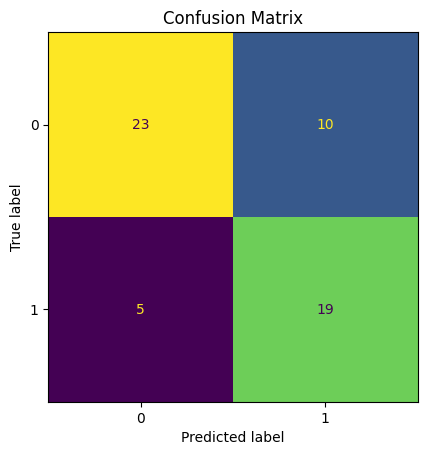

In [18]:
# Create a ConfusionMatrixDisplay instance and plot
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, best_model.predict(X_test),
                                               labels=best_model.classes_))
disp.plot(colorbar=False)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### ROC Curve

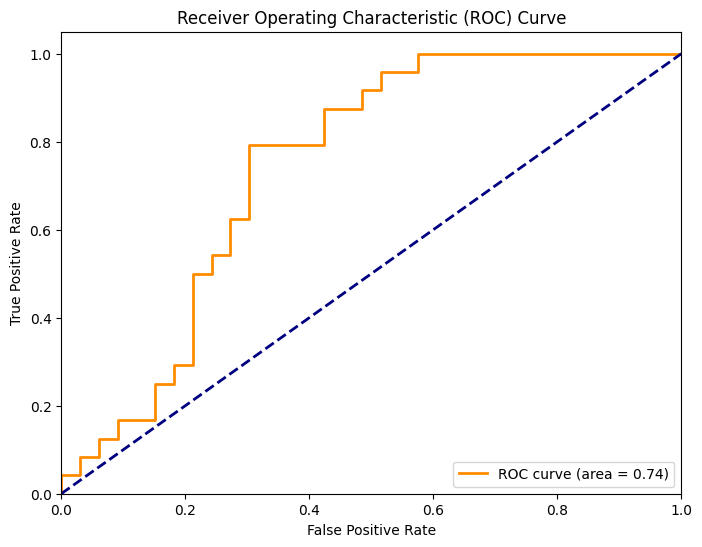

In [19]:
y_prob = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Feature Importance

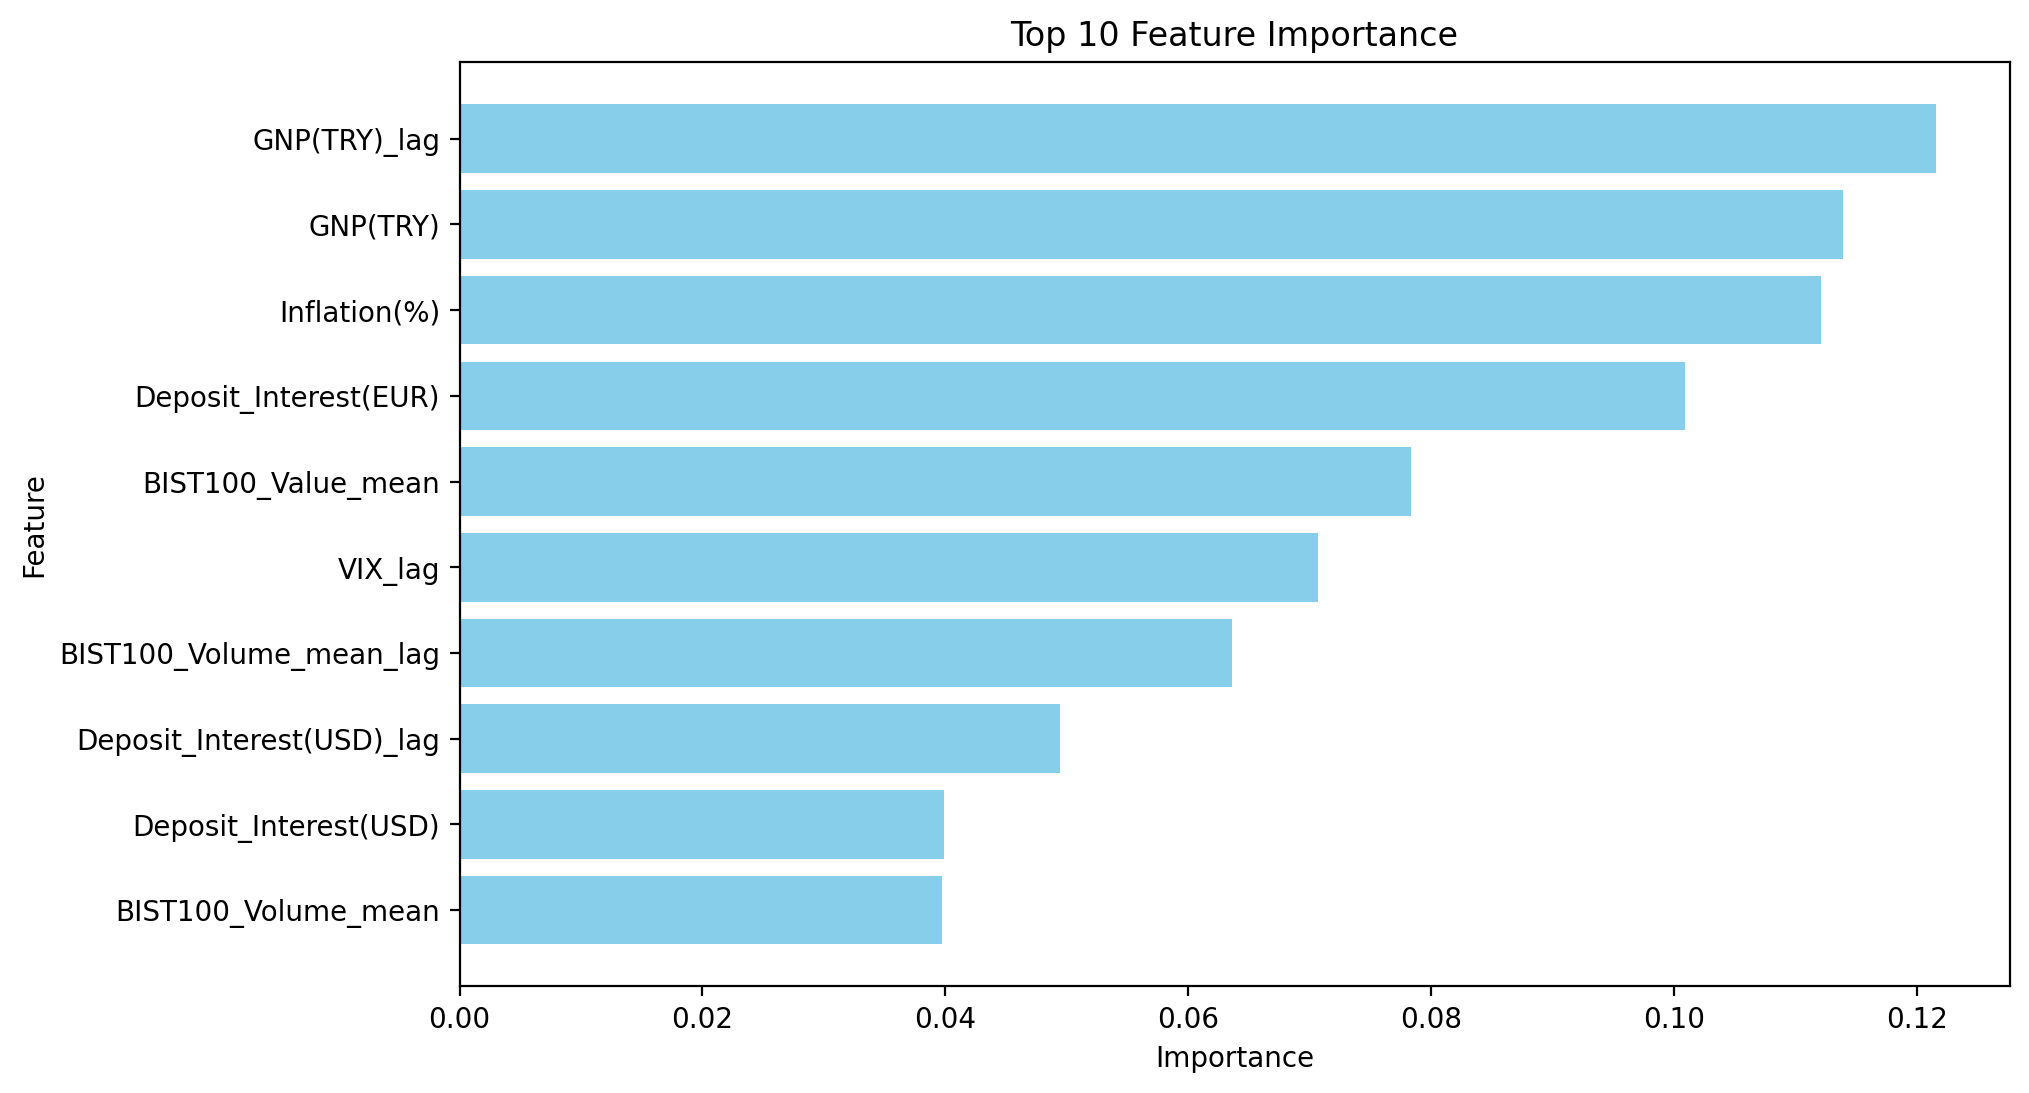

In [20]:
# Number of top features to display
top_n_features = 10

# Get feature importances from the best model and feature names from the dataset
feature_importances = best_model.feature_importances_
feature_names = X.columns

# Sort the feature importances and corresponding feature names
sorted_indices = feature_importances.argsort()
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Select the top N feature importances and names
top_feature_importances = sorted_feature_importances[-top_n_features:]
top_feature_names = sorted_feature_names[-top_n_features:]

# Plot the top N feature importances
plt.figure(figsize=(10, 6), dpi=200)
plt.barh(range(len(top_feature_importances)),
         top_feature_importances,
         color='skyblue',
         tick_label=top_feature_names)

# Customize and show the plot
plt.title("Top {} Feature Importance".format(top_n_features))
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Tree Visualization #48

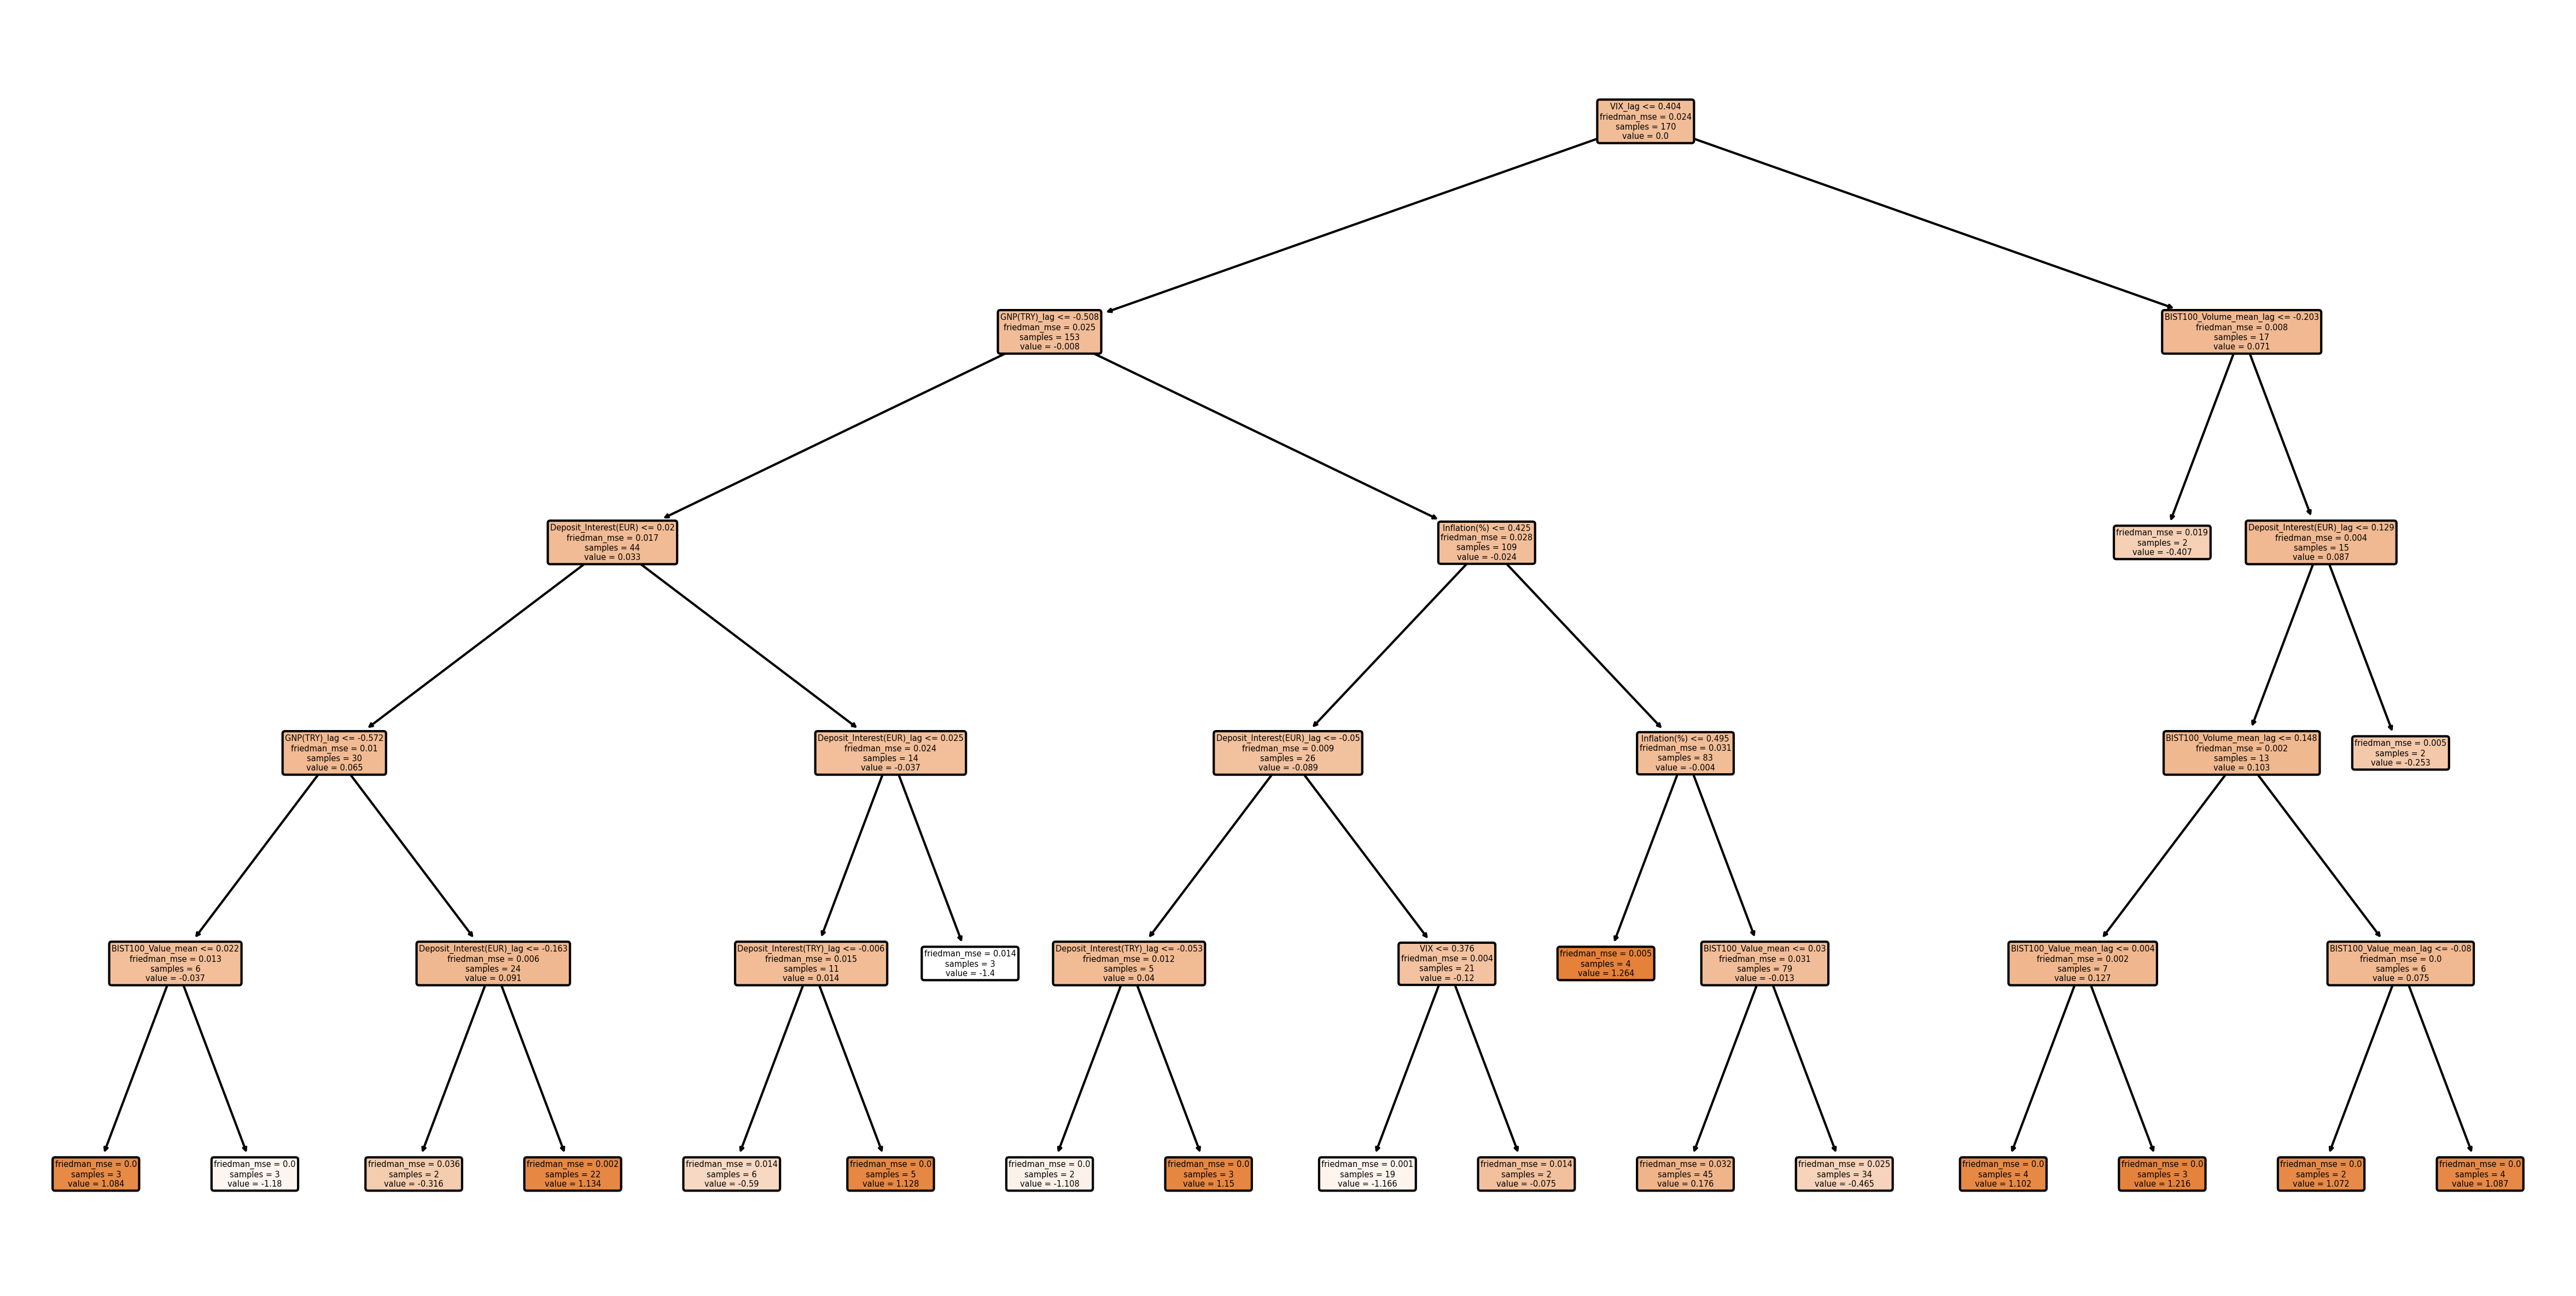

In [37]:
# Extract the 48th tree from the ensemble
estimator = best_model.estimators_[48, 0]

# Plot the tree
plt.figure(figsize=(20, 10), dpi=300)
plot_tree(
    estimator,
    filled=True,
    rounded=True,
    feature_names=X.columns,
    class_names=['Low', 'High']
)
plt.show()